In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
import xgboost as xgb
from scipy.stats import uniform, randint
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/macintosh/Desktop/Dissertation/EDA/Model_data')

In [3]:
df.head()

,Order ID,Order Item ID,Order YearMonth,Order Day,Order Time,Order Quantity,Product Department,Product Category,Product Name,Customer ID,...,Daily Demand,Restock Now,Daily Demand Std Dev,Safety Stock,Season,Season Encoded,Customer Market Encoded,Customer Region Encoded,Shipment Mode Encoded,Warehouse Country Encoded
0,1,4381,202101,1,2:48,1,Fan Shop,Water Sports,Pelican Sunstream 100 Kayak,7399,...,2.708081,0,1.510322,4.341208,Winter,0,2,3,0,0
1,2,29,202101,1,3:30,1,Apparel,Cleats,Perfect Fitness Perfect Rip Deck,918,...,11.992593,0,1.510322,4.361511,Winter,0,2,12,3,1
2,3,32,202101,1,3:30,4,Footwear,Cardio Equipment,Nike Men's Free 5.0+ Running Shoe,918,...,5.976852,1,1.510322,4.367121,Winter,0,2,12,3,1
3,4,33,202101,1,3:30,5,Fan Shop,Indoor/Outdoor Games,O'Brien Men's Neoprene Life Vest,918,...,9.964706,0,1.510322,4.386721,Winter,0,2,12,3,1
4,5,109801,202101,1,4:12,5,Footwear,Electronics,Under Armour Women's Ignite Slide,6124,...,0.231944,0,1.510322,4.264630,Winter,0,1,8,3,0


In [4]:
df.loc[0]

Order ID                                               1
Order Item ID                                       4381
Order YearMonth                                   202101
Order Day                                              1
Order Time                                          2:48
Order Quantity                                         1
Product Department                              Fan Shop
Product Category                            Water Sports
Product Name                 Pelican Sunstream 100 Kayak
Customer ID                                         7399
Customer Market                                    LATAM
Customer Region                          Central America
Customer Country                               Nicaragua
Warehouse Country                                    USA
Shipment Day                                           6
Shipment Mode                                   Same Day
Shipment Days - Scheduled                              3
Gross Sales                    

In [5]:
X = df.drop(columns=['Order ID', 'Order Item ID', 'Order YearMonth', 'Order Day', 'Order Time', 'Product Department', 'Product Category',  'EOQ', 'Reorder Point', 'date', 
                     'Season', 'Year Month', 'Shipment Mode', 'Warehouse Country', 'Customer Country', 'Customer ID', 'Product Name', 'Customer Region', 'Customer Market',
                     'Shipment Day', 'Inventory Value', 'Inventory Cost', 'Fulfillment Lag (days)', 'Safety Stock', 'Daily Demand Std Dev', 'Profit'])
y = df['EOQ']

# Split into training and testing sets
X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.7, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, test_size = 0.3, random_state=42)

In [7]:
# Normalize data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

**Feature Selection using Mutual Info Classif**

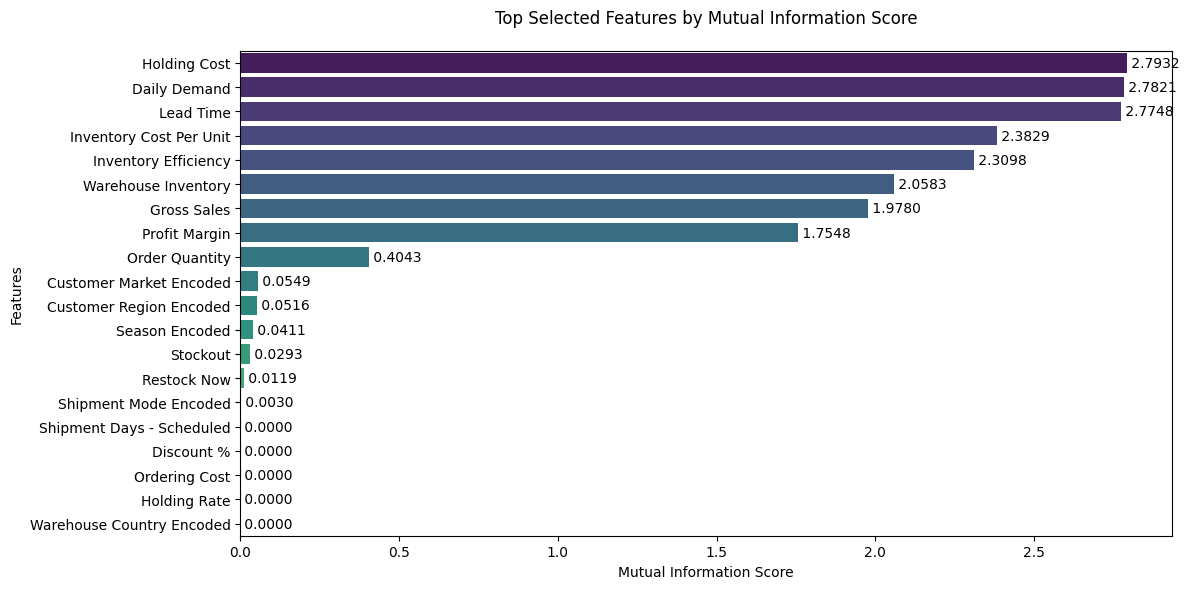

In [8]:
def select_features(X, y, n_features):
    selector = SelectKBest(score_func=mutual_info_regression, k=n_features)
    X_selected = selector.fit_transform(X, y)
    
    # Get selected feature names
    selected_features = X.columns[selector.get_support()].tolist()
    
    # Get scores for selected features
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    })
    feature_scores = feature_scores.sort_values('Score', ascending=False)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Plot feature importance scores
    sns.barplot(data=feature_scores.head(n_features), 
                x='Score', 
                y='Feature',
                palette='viridis')
    
    plt.title('Top Selected Features by Mutual Information Score', pad=20)
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    
    # Add score values on bars
    for i, v in enumerate(feature_scores.head(n_features)['Score']):
        plt.text(v, i, f' {v:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return X_selected, selected_features, feature_scores

X_selected, selected_features, feature_scores = select_features(X, y, 30)

In [9]:
def evaluate(X, y, model, subset=''):
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"\nEvaluation on {subset}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    # Feature importance
    if hasattr(model, 'coef_'):
        if isinstance(X, pd.DataFrame):
            feature_names = X.columns
        else:
            feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
            
        # Handle multiclass or multilabel classifiers 
        if model.coef_.ndim > 1:
            coefs = np.abs(model.coef_).mean(axis=0) # Average coefficients across classes
        else:
            coefs = np.abs(model.coef_)
            
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': coefs
        }).sort_values(by='Importance', ascending=False)
    
        plt.figure(figsize=(12, 6))
        sns.barplot(data=feature_importance.head(26), x='Importance', y='Feature', palette='viridis')
        plt.title(f'Feature Importance for {subset}')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.show()

**Linear Regression Model**


Evaluation on Training Set
R² Score: 0.9399
MAE: 139.6395
MSE: 41699.7336
RMSE: 204.2051


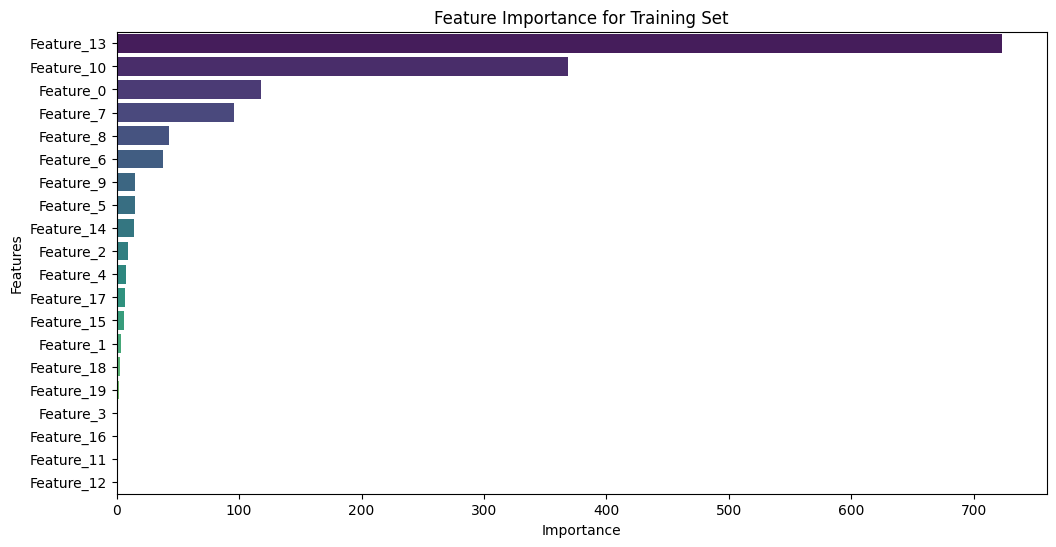


Evaluation on Validation Set
R² Score: 0.9348
MAE: 146.1721
MSE: 47184.5353
RMSE: 217.2200


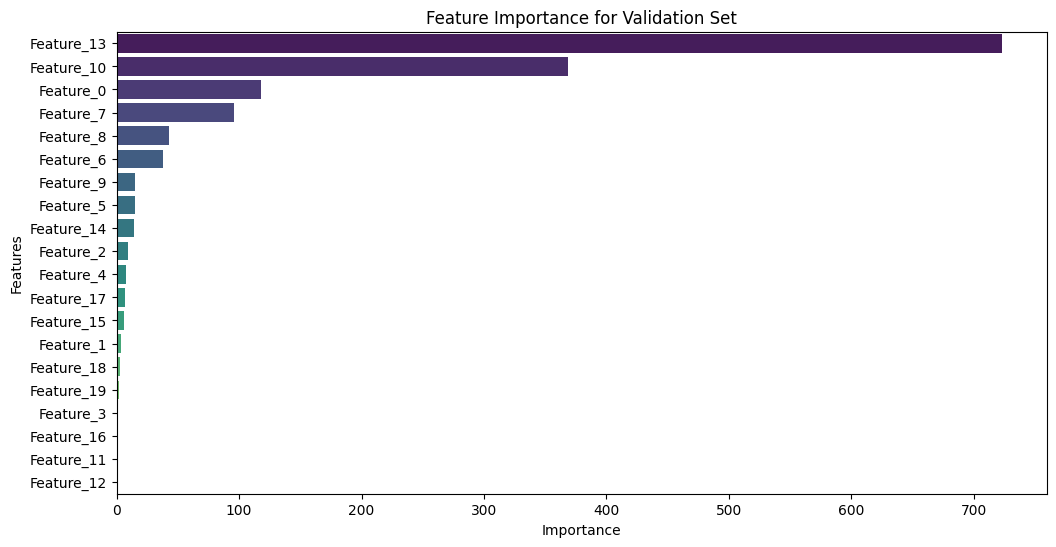

In [10]:
# Build model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Evaluate the model on training, validation, and test sets
evaluate(X_train, y_train, lr, subset='Training Set')
evaluate(X_val, y_val, lr, subset='Validation Set')

In [11]:
def plot_residuals(X, y, model, subset=''):
    # Predict EOQ values
    y_pred = model.predict(X)
    
    # Calculate residuals
    residuals = y - y_pred
    
    # Plot residuals vs predicted EOQ
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residual Plot: Residuals vs Predicted EOQ ({subset})')
    plt.xlabel('Predicted EOQ')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.show()

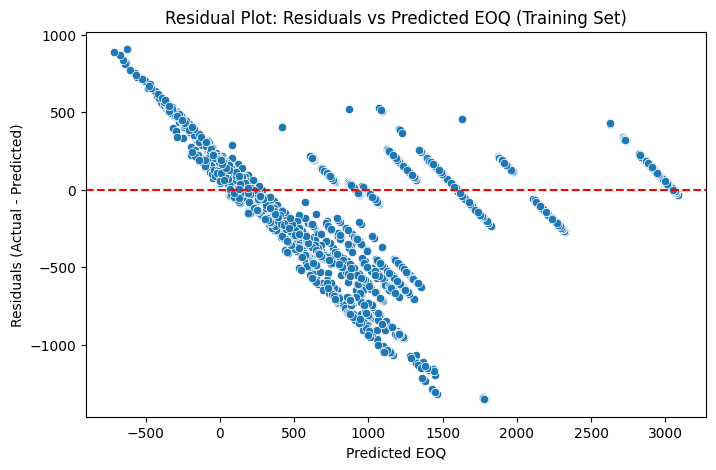

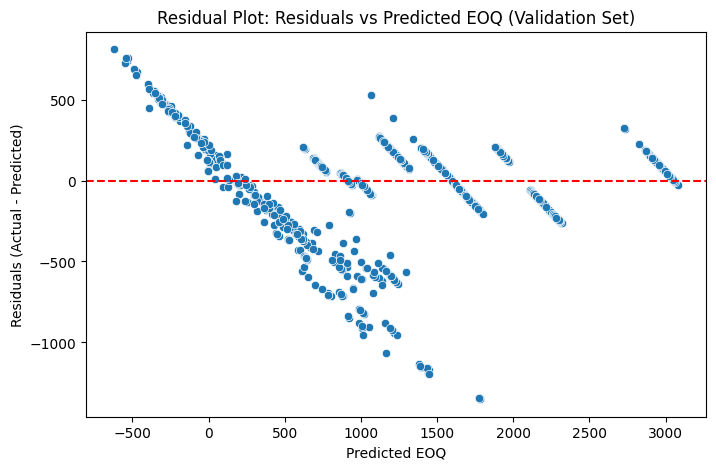

In [12]:
plot_residuals(X_train, y_train, lr, subset='Training Set')
plot_residuals(X_val, y_val, lr, subset='Validation Set')

Apply log transformation to EOQ

In [13]:
df['Log_EOQ'] = np.log(df['EOQ'] + 1)

In [14]:
X = df.drop(columns=['Order ID', 'Order Item ID', 'Order YearMonth', 'Order Day', 'Order Time', 'Product Department', 'Product Category',  'EOQ', 'Reorder Point', 'date', 
                     'Season', 'Year Month', 'Shipment Mode', 'Warehouse Country', 'Customer Country', 'Customer ID', 'Product Name', 'Customer Region', 'Customer Market',
                     'Shipment Day', 'Inventory Value', 'Inventory Cost', 'Fulfillment Lag (days)', 'Safety Stock', 'Daily Demand Std Dev', 'Profit', 'Log_EOQ'])
y = df['Log_EOQ']

# Split into training and testing sets
X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.7, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, test_size = 0.3, random_state=42)

In [15]:
# Normalize data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

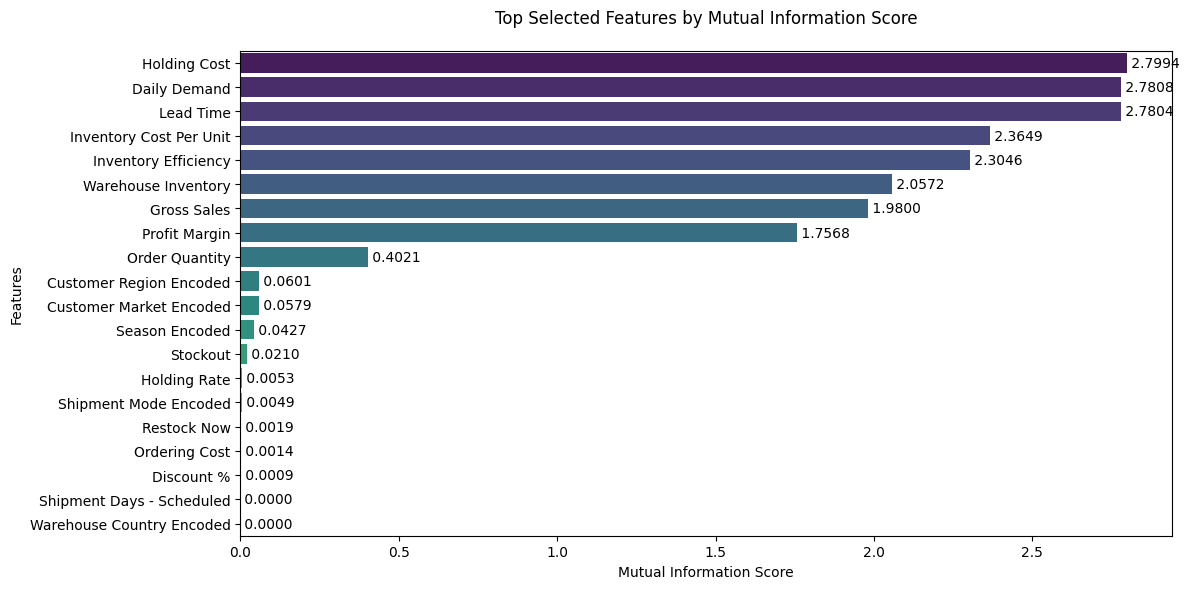

In [16]:
def select_features(X, y, n_features):
    selector = SelectKBest(score_func=mutual_info_regression, k=n_features)
    X_selected = selector.fit_transform(X, y)
    
    # Get selected feature names
    selected_features = X.columns[selector.get_support()].tolist()
    
    # Get scores for selected features
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'Score': selector.scores_
    })
    feature_scores = feature_scores.sort_values('Score', ascending=False)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Plot feature importance scores
    sns.barplot(data=feature_scores.head(n_features), 
                x='Score', 
                y='Feature',
                palette='viridis')
    
    plt.title('Top Selected Features by Mutual Information Score', pad=20)
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    
    # Add score values on bars
    for i, v in enumerate(feature_scores.head(n_features)['Score']):
        plt.text(v, i, f' {v:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return X_selected, selected_features, feature_scores

X_selected, selected_features, feature_scores = select_features(X, y, 30)

In [41]:
def evaluate(X, y, model, subset=''):
    y_pred = model.predict(X)
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"\nEvaluation on {subset}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    # Feature importance
    if hasattr(model, 'coef_'):
        if isinstance(X, pd.DataFrame):
            feature_names = X.columns
        # else:
            # feature_names = [f'Feature_{i}' for i in range(X.shape[1])]
            
        # Handle multiclass or multilabel classifiers 
        if model.coef_.ndim > 1:
            coefs = np.abs(model.coef_).mean(axis=0) # Average coefficients across classes
        else:
            coefs = np.abs(model.coef_)
            
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': coefs
        }).sort_values(by='Importance', ascending=False)
    
        plt.figure(figsize=(12, 6))
        sns.barplot(data=feature_importance.head(26), x='Importance', y='Feature', palette='viridis')
        plt.title(f'Feature Importance for {subset}')
        plt.xlabel('Importance')
        plt.ylabel('Features')
        plt.show()

In [42]:
# Build model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Evaluate the model on training, validation, and test sets
evaluate(X_train, y_train, lr, subset='Training Set')
evaluate(X_val, y_val, lr, subset='Validation Set')


Evaluation on Training Set
R² Score: 0.9399
MAE: 139.6395
MSE: 41699.7336
RMSE: 204.2051


UnboundLocalError: cannot access local variable 'feature_names' where it is not associated with a value

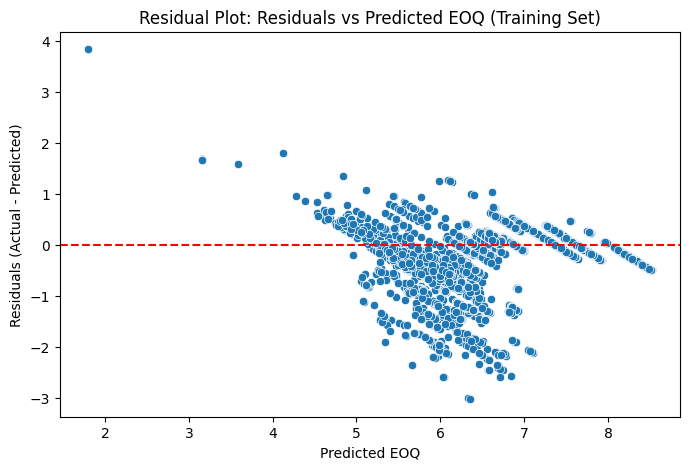

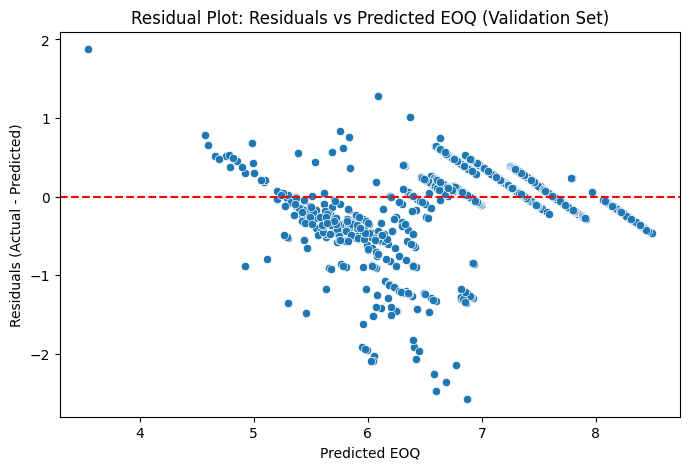

In [19]:
def plot_residuals(X, y, model, subset=''):
    # Predict EOQ values
    y_pred = model.predict(X)
    
    # Calculate residuals
    residuals = y - y_pred
    
    # Plot residuals vs predicted EOQ
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residual Plot: Residuals vs Predicted EOQ ({subset})')
    plt.xlabel('Predicted EOQ')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.show()
    
plot_residuals(X_train, y_train, lr, subset='Training Set')
plot_residuals(X_val, y_val, lr, subset='Validation Set')

### **XGBoost Regressor Model**

In [35]:
X = df.drop(columns=['Order ID', 'Order Item ID', 'Order YearMonth', 'Order Day', 'Order Time', 'Product Department', 'Product Category',  'EOQ', 'Reorder Point', 'date', 
                     'Season', 'Year Month', 'Shipment Mode', 'Warehouse Country', 'Customer Country', 'Customer ID', 'Product Name', 'Customer Region', 'Customer Market',
                     'Shipment Day', 'Inventory Value', 'Inventory Cost', 'Fulfillment Lag (days)', 'Safety Stock', 'Daily Demand Std Dev', 'Profit', 'Log_EOQ'])
y = df['EOQ']

# Split into training and testing sets
X_train, X_other, y_train, y_other = train_test_split(X, y, train_size=0.7, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_other, y_other, test_size = 0.3, random_state=42)

In [36]:
# Normalize data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)


Training XGBoost Regressor...
Training complete.

Model Evaluation (on Original EOQ Scale):
RMSE (Original Scale): 5.8139
MAE (Original Scale): 3.1137
R-squared (Original Scale): 1.0000

RMSE (Log Scale): 5.8139
MAE (Log Scale): 3.1137
R-squared (Log Scale): 1.0000


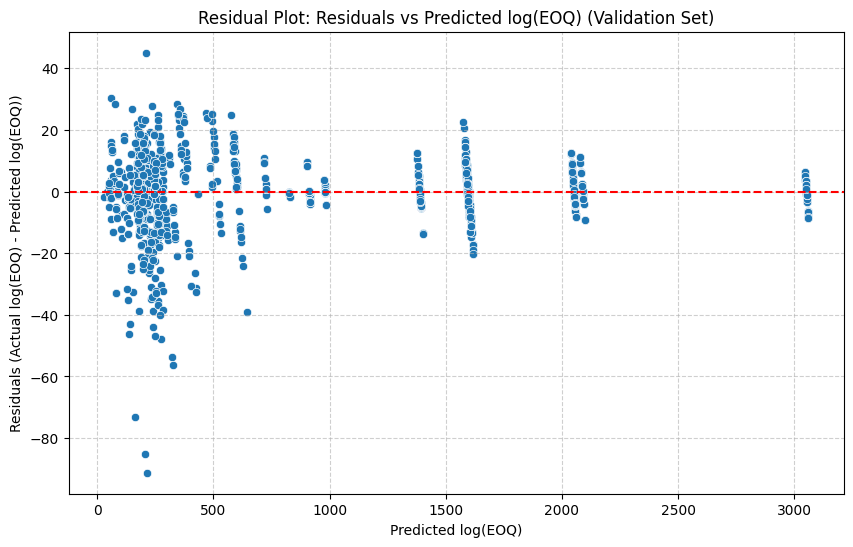

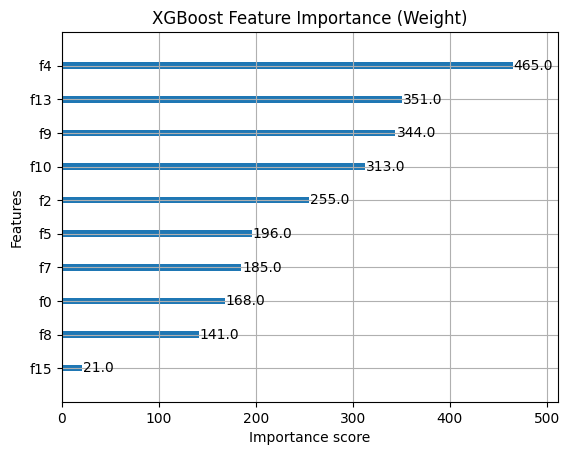


Feature Importances (Gain):
f13: 110866960.0000
f9: 48422112.0000
f10: 14594326.0000
f14: 14100349.0000
f4: 4071909.7500
f7: 1939999.5000
f2: 1194191.5000
f0: 1145814.1250
f5: 287141.4688
f8: 18118.4277
f16: 13050.5732
f6: 8108.7954
f15: 5595.1899
f3: 896.1752
f17: 416.4727
f1: 222.3648
f18: 210.2682
f19: 197.7250


In [ ]:
model = xgb.XGBRegressor(
    objective='reg:squarederror', # Default for regression, explicit is good practice
    n_estimators=100,             # Number of boosting rounds (trees)
    learning_rate=0.1,            # Step size shrinkage
    max_depth=5,                  # Maximum depth of a tree
    subsample=0.8,                # Subsample ratio of the training instance
    colsample_bytree=0.8,         # Subsample ratio of columns when constructing each tree
    random_state=42,              # For reproducibility
    tree_method='hist'            # Often faster for larger datasets
)

print("\nTraining XGBoost Regressor...")
model.fit(X_train, y_train)
print("Training complete.")

# --- 3. Make Predictions ---
# y_pred_log = model.predict(X_test)

y_pred = model.predict(X_test)

# --- 4. Back-transform Predictions for Evaluation on Original Scale ---
# Assuming you used np.log(EOQ + 1)
# y_pred_original_scale = np.exp(y_pred_log) 
# y_test_original_scale = np.exp(y_test)  # Get actual test values on original scale

# def check_array(name, arr):
#     print(f"\nChecking: {name}")
#     print("Shape:", arr.shape)
#     print("Any NaN:", np.isnan(arr).any())
#     print("Any Inf:", np.isinf(arr).any())
#     print("Max:", np.nanmax(arr))
#     print("Min:", np.nanmin(arr))

# check_array("y_test", y_test)
# check_array("y_pred_log", y_pred_log)
# check_array("y_test_original_scale", y_test_original_scale)
# check_array("y_pred_original_scale", y_pred_original_scale)

# # --- 5. Evaluate the Model ---
# print("\nModel Evaluation (on Original EOQ Scale):")
# rmse = np.sqrt(mean_squared_error(y_test_original_scale, y_pred_original_scale))
# mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
# r2 = r2_score(y_test_original_scale, y_pred_original_scale)

print("\nModel Evaluation (on Original EOQ Scale):")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE (Original Scale): {rmse:.4f}")
print(f"MAE (Original Scale): {mae:.4f}")
print(f"R-squared (Original Scale): {r2:.4f}")

# You can also evaluate on the log scale if you prefer for comparison with previous metrics
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
mae_log = mean_absolute_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)
print(f"\nRMSE (Log Scale): {rmse_log:.4f}")
print(f"MAE (Log Scale): {mae_log:.4f}")
print(f"R-squared (Log Scale): {r2_log:.4f}")

# --- 6. Plotting Residuals (After XGBoost) 

residuals = y_test - y_pred_log # Residuals on the log scale
predicted_log_eoq = y_pred_log

plt.figure(figsize=(10, 6))
sns.scatterplot(x=predicted_log_eoq, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted log(EOQ)')
plt.ylabel('Residuals (Actual log(EOQ) - Predicted log(EOQ))')
plt.title('Residual Plot: Residuals vs Predicted log(EOQ) (Validation Set)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 7. Feature Importance (XGBoost provides this directly) ---
# For plotting feature importance:
xgb.plot_importance(model, importance_type='weight', max_num_features=10) # 'weight' is default
plt.title('XGBoost Feature Importance (Weight)')
plt.show()

# You can also get it as a dictionary
feature_importances = model.get_booster().get_score(importance_type='gain')
print("\nFeature Importances (Gain):")
for feature, importance in sorted(feature_importances.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

**HyperParameter Tuning**

In [24]:
# Define the parameter distribution to sample from
param_distributions = {
    'n_estimators': randint(100, 1000), # Number of trees between 100 and 1000
    'learning_rate': uniform(0.01, 0.2), # Learning rate between 0.01 and 0.2
    'max_depth': randint(3, 10),       # Max depth between 3 and 10
    'subsample': uniform(0.6, 0.4),    # Subsample ratio between 0.6 and 1.0 (0.6 + 0.4)
    'colsample_bytree': uniform(0.6, 0.4), # Colsample_bytree between 0.6 and 1.0
    'gamma': uniform(0, 0.2),          # Gamma between 0 and 0.2
    'reg_alpha': uniform(0, 0.1),      # L1 regularization
    'reg_lambda': uniform(0, 1)        # L2 regularization
}

# Initialize RandomizedSearchCV
# estimator: Your base XGBRegressor model
# param_distributions: The dictionary of parameter distributions
# n_iter: Number of parameter settings that are sampled (adjust based on compute)
# scoring: Metric to optimize (e.g., 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_error')
# cv: Number of cross-validation folds
# verbose: Controls the verbosity of the output
# random_state: For reproducibility
# n_jobs: Number of CPU cores to use (-1 means use all available)

random_search = RandomizedSearchCV(
    estimator=model, # Use the base_regressor you defined earlier
    param_distributions=param_distributions,
    n_iter=100, # Try 100 different combinations
    scoring='neg_mean_squared_error', # Optimize for RMSE (negative MSE)
    cv=5, # 5-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train) # Use your X_train and y_train (log_EOQ or multi-output)

# Get the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best RMSE found: ", np.sqrt(-random_search.best_score_)) # Convert back from negative MSE

# Access the best model
best_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'colsample_bytree': np.float64(0.9027996528688915), 'gamma': np.float64(0.009379293558243984), 'learning_rate': np.float64(0.06373449640506147), 'max_depth': 9, 'n_estimators': 253, 'reg_alpha': np.float64(0.0498165186645893), 'reg_lambda': np.float64(0.4762106967890142), 'subsample': np.float64(0.9325485960250005)}
Best RMSE found:  0.013503371698926783



Training XGBoost Regressor...
Training complete.

Model Evaluation (on Original EOQ Scale):
RMSE (Original Scale): 2.5716
MAE (Original Scale): 1.5275
R-squared (Original Scale): 1.0000

RMSE (Log Scale): 0.0095
MAE (Log Scale): 0.0021
R-squared (Log Scale): 0.9998


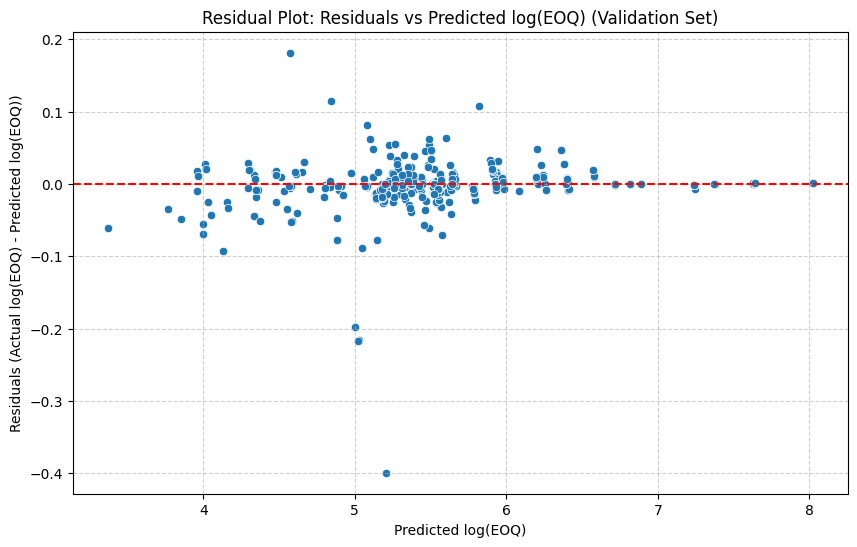

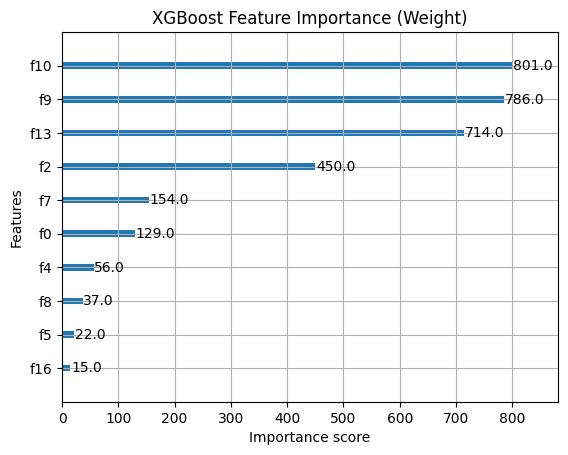


Feature Importances (Gain):
f13: 110.1772
f7: 49.3997
f4: 30.0805
f9: 12.7664
f10: 6.9195
f16: 1.5844
f2: 1.0042
f8: 0.7043
f0: 0.6739
f15: 0.3030
f5: 0.2727
f3: 0.0527
f17: 0.0186


In [25]:
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=253,            
    learning_rate=0.06,            
    max_depth=9,                
    subsample=0.9,                
    colsample_bytree=0.9,         
    random_state=42,              
    tree_method='hist',
    gamma = 0.009,
    reg_alpha = 0.05,
    reg_lambda = 0.5          
)

print("\nTraining XGBoost Regressor...")
model.fit(X_train, y_train)
print("Training complete.")

# --- 3. Make Predictions ---
y_pred_log = model.predict(X_test)

# --- 4. Back-transform Predictions for Evaluation on Original Scale ---
# Assuming you used np.log(EOQ + 1)
y_pred_original_scale = np.exp(y_pred_log) - 1
y_test_original_scale = np.exp(y_test) - 1 # Get actual test values on original scale

# --- 5. Evaluate the Model ---
print("\nModel Evaluation (on Original EOQ Scale):")
rmse = np.sqrt(mean_squared_error(y_test_original_scale, y_pred_original_scale))
mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
r2 = r2_score(y_test_original_scale, y_pred_original_scale)

print(f"RMSE (Original Scale): {rmse:.4f}")
print(f"MAE (Original Scale): {mae:.4f}")
print(f"R-squared (Original Scale): {r2:.4f}")

# You can also evaluate on the log scale if you prefer for comparison with previous metrics
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
mae_log = mean_absolute_error(y_test, y_pred_log)
r2_log = r2_score(y_test, y_pred_log)
print(f"\nRMSE (Log Scale): {rmse_log:.4f}")
print(f"MAE (Log Scale): {mae_log:.4f}")
print(f"R-squared (Log Scale): {r2_log:.4f}")

# --- 6. Plotting Residuals (After XGBoost) ---
import matplotlib.pyplot as plt
import seaborn as sns

residuals = y_test - y_pred_log # Residuals on the log scale
predicted_log_eoq = y_pred_log

plt.figure(figsize=(10, 6))
sns.scatterplot(x=predicted_log_eoq, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted log(EOQ)')
plt.ylabel('Residuals (Actual log(EOQ) - Predicted log(EOQ))')
plt.title('Residual Plot: Residuals vs Predicted log(EOQ) (Validation Set)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 7. Feature Importance (XGBoost provides this directly) ---
# For plotting feature importance:
xgb.plot_importance(model, importance_type='weight', max_num_features=10) # 'weight' is default
plt.title('XGBoost Feature Importance (Weight)')
plt.show()

# You can also get it as a dictionary
feature_importances = model.get_booster().get_score(importance_type='gain')
print("\nFeature Importances (Gain):")
for feature, importance in sorted(feature_importances.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

In [26]:
def calculate_vif(X):
    # Ensure it's a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    
    # Drop non-numeric columns if present (optional safeguard)
    X = X.select_dtypes(include=[float, int])
    
    # Add intercept term (constant)
    X_const = sm.add_constant(X)
    
    # Compute VIF for *all* columns including the constant
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_const.columns
    vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                       for i in range(X_const.shape[1])]
    
    # Optional: remove constant row from output
    vif_data = vif_data[vif_data["Feature"] != "const"]
    
    return vif_data.sort_values(by="VIF", ascending=False)

In [27]:
vif_result = calculate_vif(X_train)
print(vif_result)

   Feature       VIF
14      13  3.149621
2        1  2.553613
19      18  2.548830
8        7  2.202890
5        4  2.199262
1        0  1.797643
3        2  1.631266
15      14  1.486941
7        6  1.318038
16      15  1.200798
11      10  1.164266
9        8  1.158602
18      17  1.126718
17      16  1.084195
6        5  1.050687
10       9  1.029559
20      19  1.001142
4        3  1.000808
12      11       NaN
13      12       NaN


1     Shipment Day                    inf
9             Inventory Value         inf
11             Inventory Cost         inf
13     Fulfillment Lag (days)         inf
20               Safety Stock  950.573456
19       Daily Demand Std Dev  932.152393.  (go back n put average daily demand)
5                      Profit    5.523080





### **Random Forest**